In [102]:
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,RandomizedSearchCV,learning_curve

# Models + SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [82]:
df = pd.read_csv("earthquake_data.csv")

In [83]:
df.head(5)

,magnitude,depth,cdi,mmi,sig,alert
0,7.0,14.0,8.0,7.0,0.0,green
1,6.9,25.0,4.0,4.0,-33.0,green
2,7.0,579.0,3.0,3.0,-13.0,green
3,7.3,37.0,5.0,5.0,65.0,green
4,6.6,624.0,0.0,2.0,-98.0,green


In [84]:
df.loc[df.alert == "orange", :].head(5)

,magnitude,depth,cdi,mmi,sig,alert
14,6.6,12.0,9.0,8.0,19.0,orange
35,6.6,13.0,9.0,8.0,-12.0,orange
61,7.3,10.0,9.0,9.0,1.0,orange
73,7.1,43.0,9.0,8.0,76.0,orange
79,7.0,21.0,8.0,7.0,-9.0,orange


In [85]:
df["alert"].value_counts()

alert
green     325
yellow    325
orange    325
red       325
Name: count, dtype: int64

In [86]:
column_names = df.columns

In [87]:
x = df.iloc[:,:-1].to_numpy()
y_unenc = df.iloc[:,-1]

In [88]:
labelenc = LabelEncoder()
y = labelenc.fit_transform(y_unenc)

In [89]:
original_features = labelenc.classes_
encoded = range(len(original_features))
mapped = dict(zip(original_features,encoded))
print(mapped)

{'green': 0, 'orange': 1, 'red': 2, 'yellow': 3}


In [90]:
x_train,x_test,y_train,y_test = train_test_split(x,y,
 test_size=0.2,random_state=4,shuffle=True,stratify=y
)

Pipeline

In [93]:
xgb_model = xgb.XGBClassifier(random_state=91)
rf_model = RandomForestClassifier(random_state=92)
svc_model = SVC(random_state=3,)
knn_model = KNeighborsClassifier(p=2,metric="minkowski")
dtree = DecisionTreeClassifier(criterion="entropy",max_depth=4)
bagging_model = BaggingClassifier(estimator=dtree,random_state=192)

pipe = Pipeline([
  ("imputation", SimpleImputer(strategy="median")),
  ("scale", StandardScaler()),
  ("smote", SMOTE(random_state=84)),
  ("model", xgb_model)
])

In [99]:
param_grid = [
  { # XGBoost
    "model":[xgb_model],"model__n_estimators":[500,700,1000,1200],
    "model__learning_rate":[0.01,0.1], "model__max_depth":np.arange(4,11,2)
  },
  { # Random Forest
    "model": [rf_model],"model__n_estimators":np.arange(600,1100,100),
    "model__max_depth": np.arange(5,11,2)
  },
  { # SVC
    "model":[svc_model],"model__kernel":["rbf"],"model__C":[0.01,0.1,1,10,100],
    "model__gamma":[0.01,0.1,1,10,100]
  },
  { # KNN
    "model":[knn_model],"model__n_neighbors":np.arange(3,6,1)
  },
  { # Bagging Classifier with Decision tree estimator
    "model":[bagging_model],"model__n_estimators":[500,700,1000]
  }
]

rscv = RandomizedSearchCV(
  estimator=pipe,param_distributions=param_grid,n_iter=12,
  n_jobs=-1,cv=10,random_state=53
)

rscv.fit(x_train,y_train)
estimator = rscv.best_estimator_
score = rscv.best_score_
config = rscv.best_params_

print(f"Best configuration:\n{config}")
print(f"Best score = {score}")

Best configuration:
{'model__n_estimators': 700, 'model__max_depth': np.int64(4), 'model__learning_rate': 0.1, 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)}
Best score = 0.9048076923076923


In [100]:
y_true = y_test
y_pred = rscv.predict(x_test)
print(classification_report(y_true=y_true,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86        65
           1       0.88      0.98      0.93        65
           2       0.98      0.94      0.96        65
           3       0.86      0.85      0.85        65

    accuracy                           0.90       260
   macro avg       0.90      0.90      0.90       260
weighted avg       0.90      0.90      0.90       260



In [103]:
train_size,train_scr,val_scr = learning_curve(estimator,x_train,y_train,
 train_sizes=np.linspace(0.1,1.0,10),cv=10,random_state=65,shuffle=True,n_jobs=-1
)

train_mean = np.mean(train_scr,axis=1)
val_mean = np.mean(val_scr,axis=1)
train_std = np.std(train_scr,axis=1)
val_std = np.std(val_scr,axis=1)

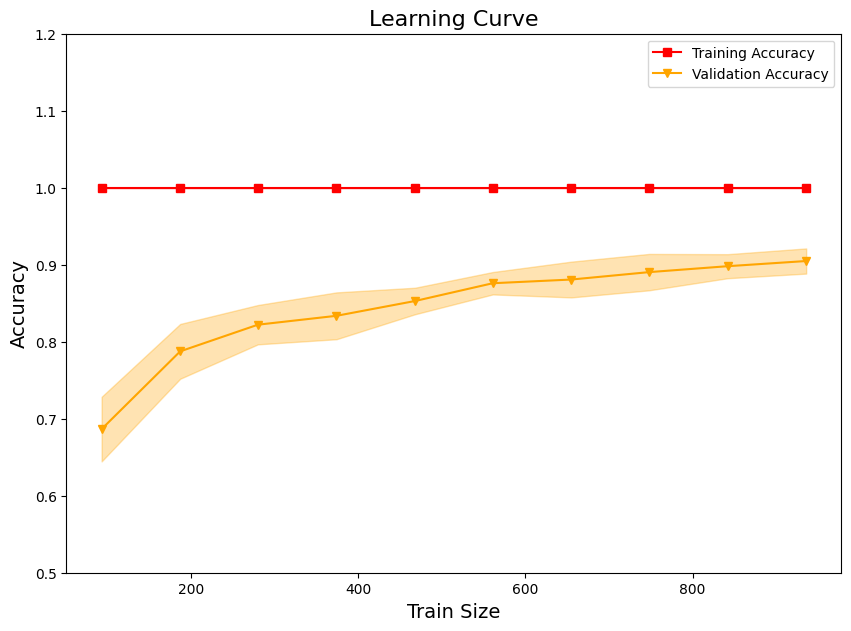

In [107]:
plt.figure(figsize=(10,7))
plt.plot(train_size,train_mean,color="red",label="Training Accuracy",marker="s")
plt.fill_between(
  train_size,train_mean + train_std, train_mean - train_std, color="red",alpha=0.3
)

plt.plot(train_size,val_mean,color="orange",label="Validation Accuracy",marker="v")
plt.fill_between(
  train_size,val_mean + val_std, val_mean - val_std, color="orange",alpha=0.3
)

plt.title("Learning Curve",fontdict={"fontsize":16})
plt.xlabel("Train Size",fontdict={"fontsize":14})
plt.ylabel("Accuracy",fontdict={"fontsize":14})
plt.ylim(0.5,1.2)
plt.legend()
plt.show()